# Action definitions and overall code framework for search problem

In [2]:
import numpy as np
import pandas as pd

from functions import *

random_state = None

In [2]:
from sklearn.datasets import make_blobs, make_hastie_10_2, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

n_samples = 1000

knn = KNeighborsClassifier(n_neighbors=1)
tree = DecisionTreeClassifier(max_depth=1)
lda = LinearDiscriminantAnalysis()
nb = GaussianNB()

models = {
    '1-NN': knn,
    'Stump': tree,
    'LDA': lda,
    'NB': nb
}

Inverting on separate datasets

In [6]:
for dataset_id in range(100):
    plt.figure()
    for name, model in models.items():
        acc = []
        X, y = load_dataset(dataset_id)

        # X, y = make_classification(n_samples=n_samples, random_state=random_state)
        
        # X, y = make_hastie_10_2(n_samples=n_samples, random_state=random_state)
        # y = np.where(y == -1, 0, y)
        
        # X, y = make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=1, random_state=random_state)

        # X, y = make_blobs(n_samples=n_samples, n_features=10, centers=1, cluster_std=1, random_state=random_state)
        # y = np.concatenate((np.zeros(n_samples//2), np.ones(n_samples//2)))
        
        for i in range(30):
            accuracy, errors = evaluate(X, y, model)
            acc.append(accuracy)
            # a means >= 15 invert random, b means < 15 invert random
            if i >= 15:
                X, y = invert_random(X, y)
            else:
                X, y = invert_errors(X, y, model)

        plt.plot(acc, label=name)


    plt.xlabel('Action iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.show()
    plt.savefig(f'a{dataset_id}.png')

C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_s

Inverting off a single dataset

[494 506]
[509 491]
[551 449]
[583 417]
[588 412]
[603 397]
[634 366]
[663 337]
[676 324]
[689 311]
[703 297]
[725 275]
[741 259]
[753 247]
[767 233]
[783 217]
[740 260]
[679 321]
[636 364]
[600 400]
[575 425]
[565 435]
[557 443]
[550 450]
[543 457]
[526 474]
[525 475]
[515 485]
[507 493]
[514 486]


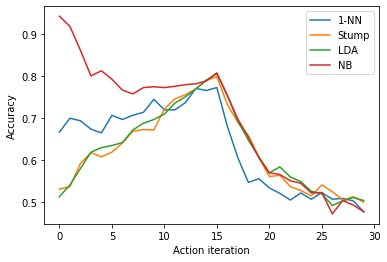

In [64]:
# X, y = make_classification(n_samples=n_samples, random_state=random_state, class_sep=1.0)

X, y = make_hastie_10_2(n_samples=n_samples, random_state=random_state)
y = np.where(y == -1, 0, y)

# X, y = make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=1, random_state=random_state)

# X, y = make_blobs(n_samples=n_samples, n_features=10, centers=1, cluster_std=1, random_state=random_state)
# y = np.concatenate((np.zeros(n_samples//2), np.ones(n_samples//2)))

acc = {name:[] for name in models}
for i in range(30):
    print(np.unique(y, return_counts=True)[1])
    for name, model in models.items():
        accuracy, errors = evaluate(X, y, model)
        acc[name].append(accuracy)
    if i >= 15:
        X, y = invert_random(X, y)
    else:
        # list(models.keys())[i % 4]
        X, y = invert_errors(X, y, models[list(models.keys())[i % 4]])

for name, values in acc.items():
    plt.plot(values, label=name)

plt.xlabel('Action iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

expertise space distribution

In [4]:
import seaborn

np_choices = [0, 1, 2]
c_choices = [0, 1]

for p in np_choices:
    for c in c_choices:
        acc = []
        folder = f'data/datasets_artificial/{p}{c}'
        ids = get_ids(folder)
        for id in ids:
            X, y = load_dataset(id, folder)
            acc.append([evaluate(X, y, model)[0] for model in models.values()])
        df = pd.DataFrame(acc, columns=models.keys(), index=ids)
        seaborn.pairplot(df).savefig(f'{p}{c}-pairwise.png')

C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_s

In [ ]:
acc = []
folder = f'data/datasets_openml/'
ids = get_ids(folder)
for id in ids:
    X, y = load_dataset(id, folder)
    acc.append([evaluate(X, y, model)[0] for model in models.values()])
df = pd.DataFrame(acc, columns=models.keys(), index=ids)
seaborn.pairplot(df).savefig(f'abcde-pairwise.png')

In [45]:
df.corr()

,1-NN,Stump,LDA,NB
1-NN,1.000000,0.505969,0.618256,0.257509
Stump,0.505969,1.000000,0.408332,0.239595
LDA,0.618256,0.408332,1.000000,0.381090
NB,0.257509,0.239595,0.381090,1.000000


In [46]:
df[(df < 0.5).any(axis=1)]

,1-NN,Stump,LDA,NB
2-1-10,0.496094,0.548828,0.500000,0.501953
2-1-11,0.531250,0.480469,0.457031,0.556641
2-1-12,0.480469,0.511719,0.488281,0.503906
2-1-13,0.535156,0.511719,0.566406,0.468750
2-1-14,0.490234,0.550781,0.550781,0.550781
...,...,...,...,...
2-1-96,0.488281,0.503906,0.484375,0.535156
2-1-97,0.468750,0.484375,0.468750,0.468750
2-1-98,0.511719,0.484375,0.503906,0.441406
2-1-99,0.531250,0.523438,0.515625,0.460938


In [49]:
np_choice = [0, 1, 2]
c_choice = [0, 1]
for p in np_choice:
    for c in c_choice:
        acc = []
        folder = f'data/datasets_artificial/{p}{c}'
        ids = get_ids(folder)
        for id in ids:
            # print(id)
            X, y = load_dataset(id, folder)
            acc.append([evaluate(X, y, model)[0] for model in models.values()])
        print(f"Uniformity score {p}{c}: {uniformity_test(np.asarray(acc))}")





Uniformity score 00: 0.056439921464111385
Uniformity score 01: 0.05906111785884244
Uniformity score 10: 0.04847084208935393
Uniformity score 11: 0.04517301743799821
Uniformity score 20: 0.21217038231170585


C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\liak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_s

Uniformity score 21: 0.4739749734168845


Uniformity score
* 00: 0.056439921464111385
* 01: 0.05906111785884244
* 10: 0.04847084208935393
* 11: 0.04517301743799821
* 20: 0.21217038231170585
* 21: 0.4739749734168845